# FastAI + UNet. Augmentation  

reference for fastAI code: https://walkwithfastai.com/Segmentation

IMPORTANT if running in PaperSpace: before running the code below, open the termnal in Jupiter and run the following code line:

apt install libgl1-mesa-glx

In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
import fastcore
from nbdev.showdoc import *

from pathlib import Path
import random

%matplotlib inline
import numpy as np

Reproducibility is importat when training. Many factors influence the outcome of the losses and error rate. However you need to set some randomness to not overfit/underfit.
The good news is that by carefully setting the random seed across your pipeline you can achieve reproducibility. The “seed” is a starting point for the sequence and the guarantee is that if you start from the same seed you will get the same sequence of numbers. That said, you also want to test your experiments across different seed values.

In [2]:
number_of_the_seed = 100

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
#My file path is being desing to look like this one. 
path = Path("../dataset2/")
#image is a normal microscope image. It's in png format. 
path_images = path/"Images"
#labels are the masks balck and white. In tif format. 
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask. 
**Important**
* Images = jpg format
* Masks = tif format 

In [4]:
get_y_fn = lambda x: path_labels/manual_name/f'Mask_{str(x.stem[-3:])}.tif'

Aux function for splitting between training and testing. In the reference website above they used a different one as they had a list of file names that were meant for traning vs testing 

In [5]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

In [6]:
codes = np.loadtxt(path/'codes.txt',dtype=str)

In [7]:
manual_name="manual"

path_manual_img = path_images/manual_name
path_manual_lbl = path_labels/manual_name

In [8]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

Example, here you are selecting just one image to check how it looks 

../dataset2/Images/manual/Droplet_438.jpg


<AxesSubplot:>

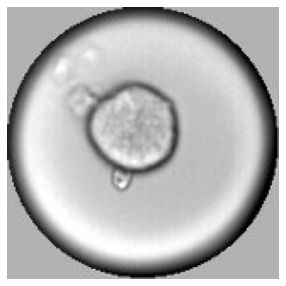

In [9]:
img_f = fnames_manual[500]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

Now, you try the get_y_fn function making sure it works and corresponds to the image above

<AxesSubplot:>

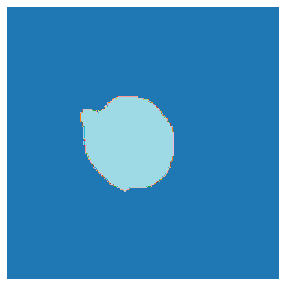

In [10]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

Visualization of the mask. It is binary, just 0 or 1. 

In [11]:
sz = mask.shape; sz

(173, 173)

Data block API is a high-level API in fastai that is an expressive API for data loading. It is a way to systematically define all of the steps necessary to prepare data for a Deep Learning model, as well as, give users a “mix and match” recipe book to use when combining these pieces.

Think of the Data Block as a list of instructions to do when you’re building batches and DataLoaders: it doesn’t explicitly need any items to be done; instead it is a blueprint of how to operate. In other words, writing a DataBlock is just like writing a blueprint.

Don't forget DataLoaders is an object that contains a training DataLoader and a validation DataLoader.
* What is the types of your inputs/targets? (Blocks)
* Where is your data? (get_items)
* Does something need to be applied to inputs? (get_x)
* Does something need to be applied to the target? (get_y)
* How to split the data? (splitter)
* Do we need to apply something on formed items? (item_tfms)
* Do we need to apply something on formed batches? (batch_tfms)
item_tfms is item transform applied on an individual item basis. This is done on the CPU. batch_tfms is batch transform applied on batches of data. This is done in GPU. https://www.educative.io/edpresso/what-is-data-block-api-in-fastai

This was previous code, you marked down it if it is failing then uncomment 

camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'codes.txt'),
                   get_y=get_y_fn,
                   item_tfms=[Resize((160,160))],
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [12]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [13]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [14]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 1
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

When we have our data, we need to make it suitable for model training. For that we use DataLoaders - it's a class that stores DataLoader objects and makes them available as train and valid.

DataLoader is a class that provides batches of a few items at a time to the GPU. When you loop through a DataLoader fastai will give you 64 (by default) items at a time, all stacked up into a single tensor.

fast.ai has developed a flexible system called the DataBlock API. At a high level, the DataBlock simply serves as a list of instructions when building batches and our DataLoaders.

Data block API system can fully customize every stage of the creation of your DataLoaders

In [15]:
manual_name="manual"
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1, seed=60),
                   item_tfms=[Resize((160,160)),TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                   
                  )
#get_items = partial(get_image_files,folders=[manual_name])
#TargetMaskConvertTransform()

We have a DataBlock object now. It acts as a template for our DataLoader, but we still need to give it a path to our data:

In [16]:
dls = camvid.dataloaders(path_manual_img, bs=32)

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Lastly let's make our vocabulary a part of our DataLoaders, as our loss function needs to deal with the Void label

In [17]:
dls.vocab = codes

In [18]:
name2id = {v:k for k,v in enumerate(codes)}

In [19]:
void_code = name2id['NoSpheroid']

IMPORTANT. The accuracy in an image segmentation problem is the same as that in any classification problem. Accuracy = no. of correctly classified pixels / total no. of pixels However in this case, some pixels are labelled as Void/NoSpheroid (this label also exists in codes.txt) and shouldn’t be considered when calculating the accuracy. Hence we make a new function for accuracy where we avoid those labels.

Loading the codes of the different classes. All the datasets have the same codes. In our case, instead of Tumour, NoTumour. We want to distnguish between cell and NoCell. These two lables are gonna be numbered (0 and 1) and those numbers will be used to label each of the pixels of the image.

The **argmax function** returns the argument or arguments (arg) for the target function that returns the maximum (max) value from the target function.

It is common for multi-class classification models to predict a vector of probabilities (or probability-like values), with one probability for each class label. The probabilities represent the likelihood that a sample belongs to each of the class labels. An array of arrays with two values the indexed 0 (cell) with a probability (float) and the index 1 (NoCell) with another probability.

Source: https://machinelearningmastery.com/argmax-in-machine-learning/

In [20]:
def accuracy(inp, targ, axis=1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    
    #the mask is the targ pixels different from NoSpheroid
    mask = targ != void_code
    
    #when the predicted pixels and targets pixels named spheroid correlates, we calculate the mean. 
    return (pred[mask] == targ[mask]).float().mean()

In [21]:
monitor_training="valid_loss"
comp_training=np.less

#metric to evaluate semantic segmentation (dicer). 
#Explanatation: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
monitor_evaluating="Dice"
comp_evaluating=np.greater

#patience: Number of epochs with no improvement after which training will be stopped.
patience=3

# First round of training 

Here we try wd = 1e-2

In [28]:
opt = Adam
learn = unet_learner(dls, resnet34, metrics=[accuracy, Dice(), JaccardCoeff()], self_attention=True, act_cls=Mish, opt_func=opt, wd=1e-2)
#self_attention=True, act_cls=Mish, opt_func=opt
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

DynamicUnet (Input shape: 32 x 3 x 160 x 160)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 80 x 80   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 40 x 40   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

SuggestedLRs(valley=2.511886486900039e-05)

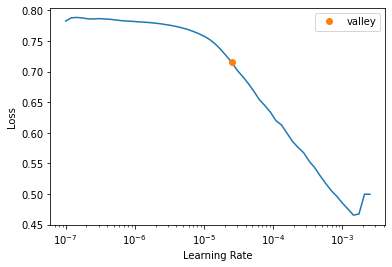

In [29]:
learn.lr_find()

The **training loss** indicates how well the model is fitting the training data, while the **validation loss** indicates how well the model fits new data.

Also *acc_camvid* function. What is it? 
The accuracy in an image segmentation problem is the same as that in any classification problem.
Accuracy = no. of correctly classified pixels / total no. of pixels
However in this case, some pixels are labelled as Void (this label also exists in codes.txt) and shouldn’t be considered when calculating the accuracy. Hence we make a new function for accuracy where we avoid those labels.

Training loss vs validation loss. Typical features of the learning curve of a good fit model
* Training loss and Validation loss are close to each other with validation loss being slightly greater than the training loss.
* Initially decreasing training and validation loss and a pretty flat training and validation loss after some point till the end

Typical features of the learning curve of an **underfit model**
1. Increasing training loss upon adding training examples.
2. Training loss and validation loss are close to each other at the end.
3. Sudden dip in the training loss and validation loss at the end (not always).

Typical features of the learning curve of an **overfit model**
1. Training loss and Validation loss are far away from each other.
2. Gradually decreasing validation loss (without flattening) upon adding training examples.
3. Very low training loss that’s very slightly increasing upon adding training examples.

**Early Stopping parameters**

The general set of strategies against this curse of overfitting is called regularization and early stopping is one such technique.

This function has been modify, it does not stop early anymore but it choose the best epoch my considering the valid loss and the Dice/Coefficient

Brief explanation about valid_loss
* If validation loss >> training loss you can call it overfitting.
* If validation loss > training loss you can call it some overfitting.
* If validation loss < training loss you can call it some underfitting.
* If validation loss << training loss you can call it underfitting.

Ideally, you make the validation loss as small as you can

epoch,train_loss,valid_loss,accuracy,dice,jaccard_coeff,time
0,3.209904,0.182824,0.566126,0.668560,0.502132,00:09
1,1.420867,0.125685,0.844378,0.817529,0.691373,00:09
2,0.834528,0.116549,0.769058,0.813725,0.685950,00:09
3,0.550828,0.098707,0.874966,0.851814,0.741878,00:09
4,0.390540,0.093641,0.859866,0.858226,0.751660,00:09
5,0.291210,0.089065,0.858276,0.865816,0.763382,00:09
6,0.226576,0.086670,0.867947,0.867865,0.766574,00:09
7,0.184117,0.091930,0.899638,0.866936,0.765125,00:09
8,0.154498,0.084125,0.890508,0.876541,0.780217,00:09
9,0.133442,0.084453,0.911312,0.877410,0.781594,00:09


Better model found at epoch 0 with valid_loss value: 0.18282362818717957.


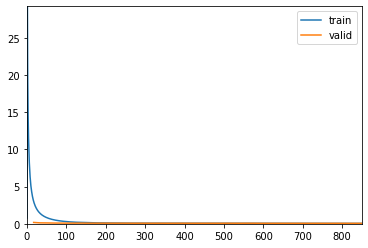

Better model found at epoch 1 with valid_loss value: 0.12568463385105133.
Better model found at epoch 2 with valid_loss value: 0.11654947698116302.
Better model found at epoch 3 with valid_loss value: 0.09870700538158417.
Better model found at epoch 4 with valid_loss value: 0.09364090114831924.
Better model found at epoch 5 with valid_loss value: 0.08906549215316772.
Better model found at epoch 6 with valid_loss value: 0.0866703912615776.
Better model found at epoch 8 with valid_loss value: 0.08412539958953857.
Better model found at epoch 11 with valid_loss value: 0.08382406830787659.
Better model found at epoch 12 with valid_loss value: 0.08189119398593903.
Better model found at epoch 14 with valid_loss value: 0.08064544945955276.
Better model found at epoch 15 with valid_loss value: 0.07677683979272842.
Better model found at epoch 20 with valid_loss value: 0.07408417761325836.
Better model found at epoch 34 with valid_loss value: 0.06984960287809372.
Better model found at epoch 38 wi

In [30]:
fname="UNet_Aug_wd2_model_1_resnet50_bs_32_Adam"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(50, slice(1e-5,1e-3),cbs=callbacksFitBeforeUnfreeze)
# cbs=callbacksFitBeforeUnfreeze
#axis below x (training size) and y, misclassification(loss)
#IMPORTANT. fit_one_cycle function does not seem to work well. Super high training/validation losses. 

just one cycle—which contains two learning rate steps, one increasing and one decreasing—and a large maximum learning rate bound. The cycle’s size must be smaller than the total number of iterations/epochs. After the cycle is complete, the learning rate should decrease even further for the remaining iterations/epochs, several orders of magnitude less than its initial value.

In [31]:
#let's check it it really saved what you wanted. 
learn.validate()

(#4) [0.059733953326940536,0.9040094017982483,0.9107178374468855,0.8360715604782318]

In [ ]:
#interp = Interpretation.from_learner(learn)
#interp.plot_top_losses(9)

* If your training loss is much lower than validation loss then this means the network might be overfitting. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
* If your training/validation loss are about equal then your model is underfitting. Increase the size of your model (either number of layers or the raw number of neurons per layer)

In [ ]:
#learn.show_results(max_n=4, figsize=(12,6))

Another way of prediction's visualizaton. Third column is suppoused to be improved. More accurate in the prediction. 

In [ ]:
preds, ys = learn.get_preds()
preds = TensorMask(preds.argmax(1))
preds.codes = codes
ys.codes = codes

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12,12), dpi=300)
for i,r in enumerate(np.random.randint(len(preds), size=4)):
    dls.valid_ds[r][0].show(ax=axes[i][0])
    preds[r].show(ax=axes[i][1])
    ys[r].show(ax=axes[i][2])

In [ ]:
#learn.save('Agumentation_valid_loss_model1')

In [32]:
learn.load("UNet_Aug_wd2_model_1_resnet50_bs_32_Adam");
learn.unfreeze()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [33]:
learn.validate()

(#4) [0.06456530839204788,0.9082270860671997,0.9053991198253962,0.8271500016343608]

Let's unfreeze the model and decrease our learning rate by 4 (Rule of thumb)

In [34]:
lr =1e-4
lrs = slice(lr/400, lr/4)
lr, lrs

(0.0001, slice(2.5e-07, 2.5e-05, None))

epoch,train_loss,valid_loss,accuracy,dice,jaccard_coeff,time
0,0.050558,0.064433,0.905910,0.905299,0.826982,00:09
1,0.050118,0.064502,0.903517,0.905073,0.826606,00:10
2,0.049713,0.064312,0.905635,0.905696,0.827646,00:10
3,0.049819,0.064616,0.905835,0.905544,0.827392,00:09
4,0.049768,0.064119,0.902255,0.905296,0.826977,00:10
5,0.049371,0.064625,0.906587,0.905862,0.827923,00:10
6,0.049060,0.065237,0.910825,0.906121,0.828356,00:10
7,0.049001,0.064828,0.899618,0.904758,0.826081,00:10
8,0.049115,0.064700,0.909821,0.905346,0.827062,00:10
9,0.048751,0.065075,0.904736,0.905039,0.826550,00:10


Better model found at epoch 0 with valid_loss value: 0.06443291157484055.


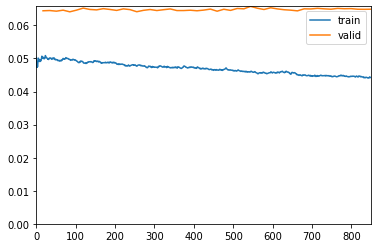

Better model found at epoch 2 with valid_loss value: 0.06431228667497635.
Better model found at epoch 4 with valid_loss value: 0.06411856412887573.


In [35]:
fname="UNet_Aug_wd2_model_2_resnet34_bs_32_Adam"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(50, lrs, cbs=callbacksFitBeforeUnfreeze)

In [ ]:
learn.show_results(max_n=5, figsize=(18,8))

In [36]:
learn.load("UNet_Aug_wd2_model_2_resnet34_bs_32_Adam");
learn.validate()

(#4) [0.06411856412887573,0.9022552371025085,0.9052956205611895,0.8269772530053094]

In [37]:
learn.unfreeze()

Recorder

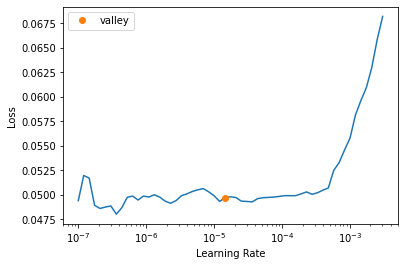

In [38]:
learn.lr_find() 
learn.recorder

In [39]:
lrs = slice(1e-7,5e-6)

epoch,train_loss,valid_loss,accuracy,dice,jaccard_coeff,time
0,0.048770,0.064325,0.906961,0.905846,0.827896,00:10
1,0.048963,0.064682,0.905123,0.905425,0.827193,00:10
2,0.048945,0.064739,0.906238,0.905627,0.827531,00:10
3,0.048800,0.064703,0.903289,0.905368,0.827097,00:10
4,0.048441,0.064647,0.906314,0.905797,0.827815,00:10
5,0.048732,0.064958,0.905759,0.905455,0.827243,00:10
6,0.048609,0.064629,0.908423,0.905934,0.828044,00:10
7,0.048509,0.064671,0.908763,0.905815,0.827845,00:10
8,0.048450,0.064719,0.905669,0.905532,0.827371,00:10
9,0.048522,0.064700,0.904293,0.905488,0.827298,00:10


Better model found at epoch 0 with valid_loss value: 0.06432526558637619.


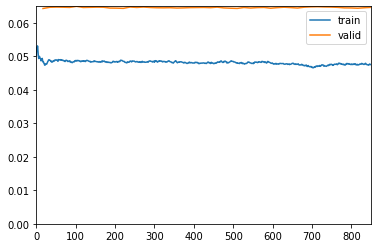

In [40]:
fname="UNet_Aug_wd2_model_3_resnet34_bs_32_Adam"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(50, lrs ,cbs=callbacksFitBeforeUnfreeze)

In [41]:
learn.validate()

(#4) [0.06432526558637619,0.9069605469703674,0.9058457126212722,0.8278957758246439]

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

In [42]:
learn.load("UNet_Aug_wd2_model_3_resnet34_bs_32_Adam");
learn.validate()

(#4) [0.06432526558637619,0.9069605469703674,0.9058457126212722,0.8278957758246439]

Recorder

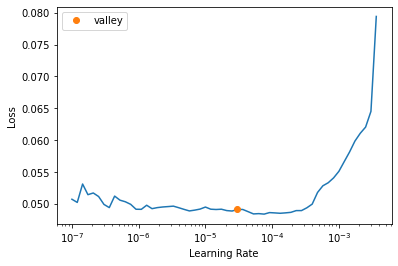

In [43]:
learn.unfreeze()
learn.lr_find() 
learn.recorder

epoch,train_loss,valid_loss,accuracy,dice,jaccard_coeff,time
0,0.048896,0.064314,0.903599,0.905749,0.827733,00:10
1,0.049040,0.064233,0.904517,0.905999,0.828153,00:10
2,0.048919,0.064207,0.908019,0.906390,0.828805,00:10
3,0.048507,0.064335,0.906732,0.906302,0.828658,00:10
4,0.048357,0.064343,0.902663,0.905782,0.827789,00:10
5,0.048559,0.064413,0.903426,0.905657,0.827581,00:10
6,0.048473,0.064251,0.905275,0.906167,0.828432,00:10
7,0.048345,0.063977,0.909438,0.906578,0.829119,00:10
8,0.048270,0.064221,0.905972,0.906003,0.828159,00:10
9,0.048118,0.064139,0.906821,0.906149,0.828403,00:10


Better model found at epoch 0 with valid_loss value: 0.06431447714567184.


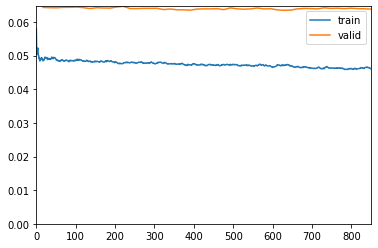

Better model found at epoch 1 with valid_loss value: 0.06423326581716537.
Better model found at epoch 2 with valid_loss value: 0.0642070397734642.
Better model found at epoch 7 with valid_loss value: 0.06397698074579239.
Better model found at epoch 13 with valid_loss value: 0.06397584825754166.
Better model found at epoch 14 with valid_loss value: 0.06397013366222382.
Better model found at epoch 18 with valid_loss value: 0.06367886066436768.
Better model found at epoch 20 with valid_loss value: 0.06361192464828491.
Better model found at epoch 21 with valid_loss value: 0.06359390914440155.
Better model found at epoch 22 with valid_loss value: 0.06349644809961319.
Better model found at epoch 36 with valid_loss value: 0.06346236169338226.


In [44]:
fname="UNet_Aug_wd2_model_4_resnet34_bs_32_Adam"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(50, slice(9e-6,1e-6) ,cbs=callbacksFitBeforeUnfreeze)

# Second training round 

Now we try with wd = 1e-1

In [22]:
opt = Adam
learn = unet_learner(dls, resnet34, metrics=[accuracy, Dice(), JaccardCoeff()], self_attention=True, act_cls=Mish, opt_func=opt, wd=1e-1)
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

DynamicUnet (Input shape: 32 x 3 x 160 x 160)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 80 x 80   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 40 x 40   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

Recorder

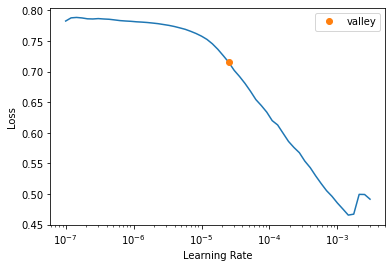

In [29]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,accuracy,dice,jaccard_coeff,time
0,3.273950,0.199817,0.451555,0.564107,0.392862,00:09
1,1.448910,0.132506,0.791730,0.801606,0.668901,00:09
2,0.920608,0.127377,0.830991,0.809335,0.679734,00:09
3,0.616888,0.119169,0.830295,0.821497,0.697069,00:10
4,0.438877,0.102985,0.834949,0.846226,0.733442,00:09
5,0.327551,0.096238,0.869213,0.860345,0.754917,00:09
6,0.253386,0.090296,0.856779,0.863289,0.759462,00:09
7,0.204658,0.100937,0.906428,0.861456,0.756630,00:10
8,0.169931,0.087237,0.898588,0.872525,0.773875,00:09
9,0.145354,0.082798,0.867125,0.874015,0.776223,00:09


Better model found at epoch 0 with valid_loss value: 0.1998167484998703.


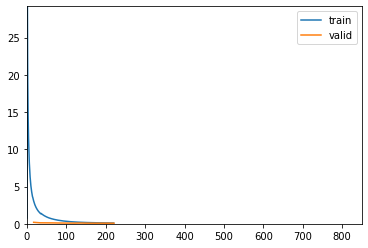

Better model found at epoch 1 with valid_loss value: 0.1325055956840515.
Better model found at epoch 2 with valid_loss value: 0.12737663090229034.
Better model found at epoch 3 with valid_loss value: 0.11916907131671906.
Better model found at epoch 4 with valid_loss value: 0.1029849424958229.
Better model found at epoch 5 with valid_loss value: 0.09623797237873077.
Better model found at epoch 6 with valid_loss value: 0.09029626101255417.
Better model found at epoch 8 with valid_loss value: 0.08723661303520203.
Better model found at epoch 9 with valid_loss value: 0.08279849588871002.
Better model found at epoch 11 with valid_loss value: 0.08158209919929504.
Better model found at epoch 12 with valid_loss value: 0.08099126070737839.


In [ ]:
fname="UNet_Aug_wd1_model_1_resnet34_bs_32_Adam"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(50, slice(8e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

In [31]:
learn.load("UNet_Aug_wd1_model_1_resnet34_bs_32_Adam");
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.06448560208082199,0.9188982248306274,0.9088279912349961,0.8328915917331989]

In [32]:
lr =7e-3
lrs = slice(lr/400, lr/4)
lr, lrs

(0.007, slice(1.7500000000000002e-05, 0.00175, None))

In [33]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,dice,jaccard_coeff,time
0,0.045647,0.071819,0.938151,0.899059,0.816628,00:06
1,0.046190,0.069677,0.904807,0.903978,0.824781,00:07
2,0.046744,0.066699,0.888179,0.900168,0.818460,00:07
3,0.046899,0.066137,0.897965,0.901198,0.820164,00:07
4,0.048323,0.071427,0.887912,0.897405,0.813903,00:07
5,0.049010,0.069176,0.896756,0.901075,0.819961,00:07
6,0.049665,0.077815,0.884104,0.889778,0.801442,00:06
7,0.050646,0.080924,0.900746,0.893483,0.807473,00:07
8,0.050790,0.074209,0.894034,0.893126,0.806891,00:07
9,0.051115,0.070732,0.874918,0.893150,0.806930,00:07


Better model found at epoch 0 with valid_loss value: 0.07181911915540695.


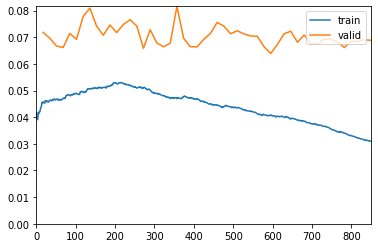

Better model found at epoch 1 with valid_loss value: 0.06967678666114807.
Better model found at epoch 2 with valid_loss value: 0.06669945269823074.
Better model found at epoch 3 with valid_loss value: 0.06613652408123016.
Better model found at epoch 15 with valid_loss value: 0.06586168706417084.
Better model found at epoch 34 with valid_loss value: 0.06389455497264862.


In [34]:
fname="UNet_Aug_wd1_model_2_resnet34_bs_32_Adam"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(50, lrs ,cbs=callbacksFitBeforeUnfreeze)

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

In [35]:
learn.load("UNet_Aug_wd1_model_2_resnet34_bs_32_Adam");
learn.validate()

(#4) [0.06389455497264862,0.8976665735244751,0.9082924039255917,0.8319923825680559]

In [36]:
learn.unfreeze()

Recorder

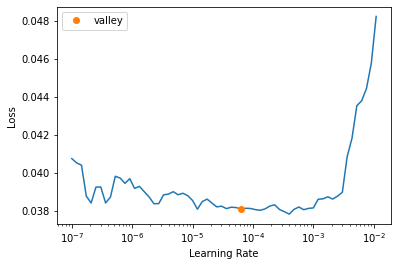

In [37]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [38]:
lrs = slice(6e-6, 8e-5)

epoch,train_loss,valid_loss,accuracy,dice,jaccard_coeff,time
0,0.037907,0.063322,0.915727,0.911272,0.837006,00:06
1,0.037905,0.064243,0.921035,0.911689,0.837710,00:06
2,0.037361,0.064439,0.912036,0.911455,0.837315,00:06
3,0.036324,0.064921,0.914906,0.911650,0.837643,00:06
4,0.035876,0.065786,0.913188,0.911567,0.837504,00:06
5,0.035545,0.065808,0.910723,0.911784,0.837871,00:06
6,0.034837,0.066329,0.911508,0.911655,0.837652,00:06
7,0.034448,0.066795,0.915467,0.912273,0.838697,00:06
8,0.034369,0.066324,0.908935,0.911798,0.837894,00:06
9,0.033944,0.066314,0.910624,0.912310,0.838760,00:06


Better model found at epoch 0 with valid_loss value: 0.06332247704267502.


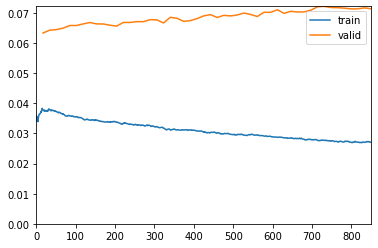

In [39]:
fname="UNet_Aug_wd1_model_3_resnet34_bs_32_Adam"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(50, lrs ,cbs=callbacksFitBeforeUnfreeze)

In [ ]:
learn.validate()

In [29]:
learn.load("UNet_Aug_wd1_model_3_resnet34_bs_32_Adam");
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.06332247704267502,0.9157271981239319,0.9112720536541273,0.8370062114347799]

Recorder

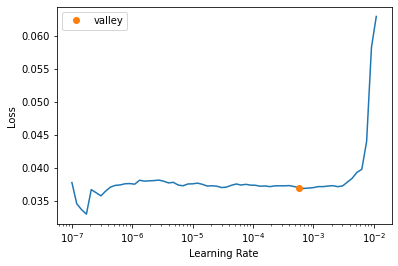

In [30]:
learn.unfreeze()
learn.lr_find()
learn.recorder

epoch,train_loss,valid_loss,accuracy,dice,jaccard_coeff,time
0,0.037659,0.063452,0.916468,0.911338,0.837117,00:06
1,0.037205,0.063682,0.915865,0.911177,0.836847,00:06
2,0.037379,0.063678,0.915389,0.911295,0.837044,00:07
3,0.036841,0.063788,0.915285,0.911438,0.837286,00:06
4,0.036994,0.063840,0.916101,0.911552,0.837479,00:07
5,0.036938,0.063991,0.916180,0.911525,0.837433,00:07
6,0.036824,0.063991,0.917087,0.911761,0.837831,00:07
7,0.036867,0.064190,0.915657,0.911650,0.837645,00:07
8,0.036930,0.064236,0.915688,0.911720,0.837763,00:07
9,0.036770,0.064258,0.915639,0.911769,0.837846,00:07


Better model found at epoch 0 with valid_loss value: 0.06345243752002716.


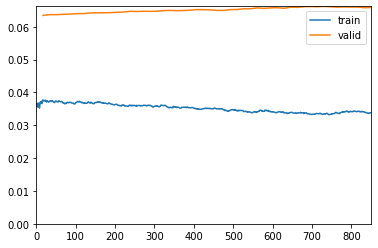

In [31]:
fname="UNet_Aug_wd1_model_4_resnet34_bs_32_Adam"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(50, slice(1e-7,8e-6) ,cbs=callbacksFitBeforeUnfreeze)

# Third round of training 

Here we try with wd = 1e-3

In [28]:
opt = Adam
learn = unet_learner(dls, models.resnet34, metrics=[accuracy, Dice(), JaccardCoeff()], self_attention=True, act_cls=Mish, opt_func=opt, wd=1e-3)
learn.summary()

DynamicUnet (Input shape: 32 x 3 x 160 x 160)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 80 x 80   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 40 x 40   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

Recorder

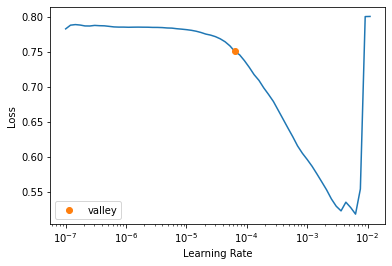

In [29]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,accuracy,dice,jaccard_coeff,time
0,0.475889,0.178518,0.653765,0.716810,0.558616,00:06
1,0.282575,0.115714,0.814776,0.824747,0.701761,00:06
2,0.203796,0.099760,0.814376,0.840301,0.724585,00:06
3,0.160745,0.089199,0.837014,0.859102,0.753006,00:06
4,0.136156,0.089533,0.823710,0.856858,0.749564,00:06
5,0.119936,0.085988,0.905615,0.872514,0.773858,00:06
6,0.108322,0.085773,0.890444,0.870683,0.770982,00:06
7,0.098802,0.081444,0.858848,0.874587,0.777126,00:06
8,0.093057,0.083797,0.855272,0.872242,0.773430,00:06
9,0.088078,0.079819,0.901816,0.879056,0.784211,00:06


Better model found at epoch 0 with valid_loss value: 0.17851826548576355.


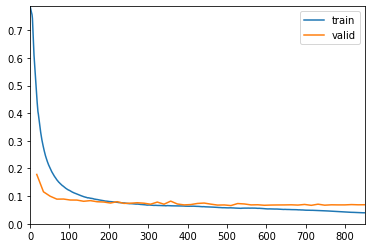

Better model found at epoch 1 with valid_loss value: 0.11571426689624786.
Better model found at epoch 2 with valid_loss value: 0.09975987672805786.
Better model found at epoch 3 with valid_loss value: 0.08919885009527206.
Better model found at epoch 5 with valid_loss value: 0.08598770946264267.
Better model found at epoch 6 with valid_loss value: 0.08577266335487366.
Better model found at epoch 7 with valid_loss value: 0.08144424110651016.
Better model found at epoch 9 with valid_loss value: 0.07981907576322556.
Better model found at epoch 10 with valid_loss value: 0.0787590891122818.
Better model found at epoch 11 with valid_loss value: 0.07503733038902283.
Better model found at epoch 13 with valid_loss value: 0.0738605335354805.
Better model found at epoch 17 with valid_loss value: 0.07088705152273178.
Better model found at epoch 19 with valid_loss value: 0.07086692750453949.
Better model found at epoch 22 with valid_loss value: 0.0683988705277443.
Better model found at epoch 27 with

In [30]:
fname="UNet_Aug_wd3_model_1_resnet34_bs_32_Adam"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(50, slice(1e-4,1e-3) ,cbs=callbacksFitBeforeUnfreeze)

In [31]:
learn.validate()

(#4) [0.06595169752836227,0.8889140486717224,0.8994262265315757,0.8172339267153911]

In [32]:
lr = 7e-3
lrs = slice(lr/400, lr/4)
lr, lrs

(0.007, slice(1.7500000000000002e-05, 0.00175, None))

In [33]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,dice,jaccard_coeff,time
0,0.055228,0.067062,0.907265,0.898705,0.816045,00:06
1,0.055396,0.074023,0.873832,0.890496,0.802607,00:07
2,0.057637,0.069302,0.885523,0.893722,0.807863,00:07
3,0.057902,0.070552,0.906247,0.896616,0.812606,00:06
4,0.059039,0.072832,0.869532,0.890881,0.803233,00:07
5,0.058883,0.065669,0.894045,0.900383,0.818815,00:06
6,0.058786,0.090789,0.902990,0.890501,0.802616,00:07
7,0.058236,0.069151,0.920618,0.899854,0.817940,00:06
8,0.058054,0.069753,0.902701,0.896044,0.811666,00:07
9,0.057943,0.066295,0.898146,0.900504,0.819016,00:06


Better model found at epoch 0 with valid_loss value: 0.06706161797046661.


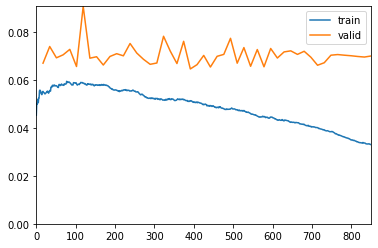

Better model found at epoch 5 with valid_loss value: 0.06566942483186722.
Better model found at epoch 22 with valid_loss value: 0.06466253101825714.


In [34]:
fname="UNet_Aug_wd3_model_2_resnet34_bs_32_Adam"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(50, lrs ,cbs=callbacksFitBeforeUnfreeze)

In [35]:
learn.load("UNet_Aug_wd3_model_2_resnet34_bs_32_Adam")
learn.validate()

(#4) [0.06466253101825714,0.8925502300262451,0.9008079096301197,0.819518187514428]

Recorder

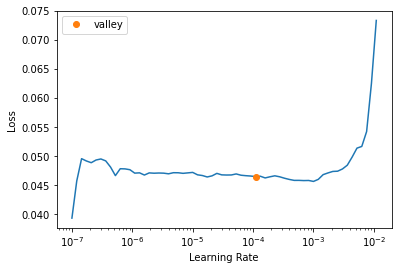

In [36]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder

In [37]:
lrs = slice(1e-7,3e-6)

epoch,train_loss,valid_loss,accuracy,dice,jaccard_coeff,time
0,0.046439,0.064559,0.894367,0.901394,0.820488,00:06
1,0.046484,0.064614,0.895311,0.901426,0.820542,00:06
2,0.046418,0.064452,0.897151,0.901947,0.821405,00:06
3,0.046489,0.064574,0.898121,0.902120,0.821692,00:07
4,0.046599,0.064367,0.900124,0.902653,0.822578,00:07
5,0.046176,0.064491,0.902332,0.902935,0.823045,00:06
6,0.045887,0.064583,0.903544,0.903211,0.823504,00:06
7,0.046098,0.064713,0.904024,0.903152,0.823406,00:07
8,0.045588,0.064665,0.905536,0.903560,0.824085,00:07
9,0.045399,0.064679,0.906859,0.903933,0.824706,00:06


Better model found at epoch 0 with valid_loss value: 0.06455888599157333.


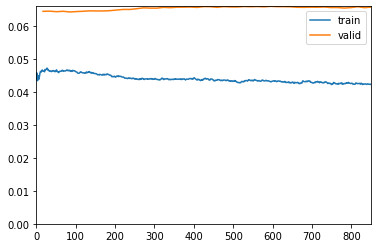

Better model found at epoch 2 with valid_loss value: 0.06445246189832687.
Better model found at epoch 4 with valid_loss value: 0.06436698138713837.


In [38]:
fname="UNet_Aug_wd3_model_3_resnet34_bs_32_Adam"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(50, lrs ,cbs=callbacksFitBeforeUnfreeze)

In [29]:
learn.load("UNet_Aug_wd3_model_3_resnet34_bs_32_Adam")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.06436698138713837,0.9001240730285645,0.902653193984563,0.822577866027766]

Recorder

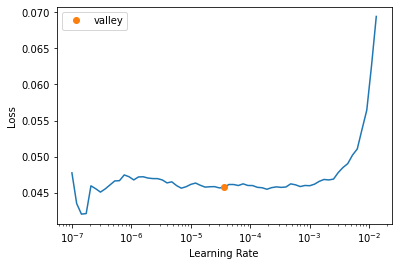

In [30]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder

epoch,train_loss,valid_loss,accuracy,dice,jaccard_coeff,time
0,0.046016,0.064410,0.902256,0.903045,0.823228,00:07
1,0.045910,0.064690,0.904240,0.903256,0.823580,00:07
2,0.045816,0.064824,0.906330,0.903622,0.824189,00:07
3,0.045302,0.065019,0.907568,0.903900,0.824651,00:07
4,0.045501,0.065116,0.909391,0.904374,0.825440,00:07
5,0.045138,0.065275,0.909115,0.904333,0.825371,00:06
6,0.044758,0.065439,0.910666,0.904756,0.826077,00:07
7,0.044457,0.065645,0.909487,0.904731,0.826036,00:07
8,0.044355,0.065820,0.909352,0.904715,0.826009,00:07
9,0.044186,0.065799,0.908405,0.904748,0.826063,00:07


Better model found at epoch 0 with valid_loss value: 0.06440991163253784.


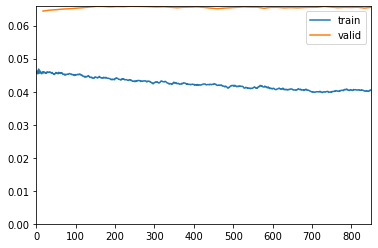

In [31]:
fname="UNet_Aug_wd3_model_4_resnet34_bs_32_Adam"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(50, slice(2e-7,9e-6) ,cbs=callbacksFitBeforeUnfreeze)

# MASK PREDICTION 

In [23]:
learn.load('UNet_Aug_wd1_model_3_resnet34_bs_32')
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.06332197040319443,0.9157493710517883,0.9112597975325394,0.8369855319637418]

To check the validation loss and acurracy of our model

In [24]:
path2 = path_images/"figure"
path2

Path('../dataset2/Images/figure')

It doesn't work when I substitute path2 for fnames_test because the datablock itself contains the function get_images_files. Therefore, it is redundant and code brakes. 

fnames_test = get_image_files(path2)

type(fnames_test)

Result: fastcore.foundation.L


In [25]:
dblock = DataBlock(blocks=(ImageBlock),get_items = get_image_files, item_tfms=Resize((160,160)), batch_tfms=Normalize.from_stats(*imagenet_stats))
learn.dls =  dblock.dataloaders(path2, bs=2, num_workers=0)

In [ ]:
ls = path2.ls()
ls
i = 17
preds =learn.predict(ls[i])
pred_1 = preds[0][1]
plt.imshow(pred_1)

In [ ]:
ls = path2.ls()

In [ ]:
i = 0

In [ ]:
preds =learn.predict(ls[i])

In [ ]:
preds[2].shape

I now undestrand why it does not work. 
* Preds[0] contains three lists each of them with some lists inside with repeated numbers (123, 126, 103). Shape: [3, 160, 160]. Three lists with 160 rows and 160 columns. 
* Preds[1] contains one lists with some lists inside (0 and maybe 1). Size: 160,160
* Preds[2] contains three lists, with some other inside. These ones contain nubers between 0 and 1 and my guess it's they belong to the accuracy of each assignation. Size: [2, 160, 160]. From that list one is the probability of being an spheroid and the other one of NOT being an spheroid. 

My hypothesis: preds_1 is the mask perse, preds_2 is the probability/accuracy of the asignation. Preds_0 no clue at all but this is a tensorImage and the others are TensorBase.

In [ ]:
pred_1 = preds[0][0]
pred_1.shape


dim=0 means row-wise

In [ ]:
pred_arx = pred_1.argmax(dim=0)

In [ ]:
plt.imshow(pred_1)

In [ ]:
img = ls[i]
PILImage.create(img)

In [3]:
ls[i]

ls: cannot access '[i]': No such file or directory


In [4]:
#model = learn.load('trial_1')
#learn3 = model.get_preds()
#learn3

In [31]:
import os 
import ntpath
#os.mkdir('Predicted_masks_UNet_figure')
for file in path2.ls():
    filename = os.path.basename(file)
    
    if "jpg" in os.path.basename(file):
        
        trial = ntpath.basename(file)
        
        preds =learn.predict(file)
        pred_1 = preds[0][1]
        pred_arx = pred_1.numpy()
        rescaled = (755.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)
        im = Image.fromarray(rescaled) 
        name_jpg = filename
        name_tif = trial[:-4] +  ".tif"
        im.save(f"Predicted_masks_UNet_figure/{name_tif}")        
    else: 
        print("are you sure this is a jpg file? :)")